In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,\
      MaxPool2D, Conv2D, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ModelCheckpoint 

In [2]:
IMG_SIZE=28
batch_size=200
epochs=30

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
x_train = x_train[..., tf.newaxis].astype('float32')
x_test = x_test[..., tf.newaxis].astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train) 
y_test = np_utils.to_categorical(y_test)

In [5]:
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE,IMG_SIZE,1)))
# classifier.add(BatchNormalization(axis=-1))  
classifier.add(Activation('relu'))

classifier.add(Conv2D(32, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(MaxPool2D(pool_size=(2,2)))
# classifier.add(BatchNormalization(axis=-1))

classifier.add(Conv2D(64, (3,3)))
# classifier.add(BatchNormalization(axis=-1))
classifier.add(Activation('relu'))

classifier.add(Conv2D(64, (3,3)))
classifier.add(Activation('relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Flatten())
# classifier.add(BatchNormalization())

classifier.add(Dense(512))
# classifier.add(BatchNormalization())
classifier.add(Activation('relu'))

classifier.add(Dropout(0.2))
classifier.add(Dense(10))
classifier.add(Activation('softmax'))

In [6]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
classifier.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [8]:
train_gen = ImageDataGenerator(rotation_range=15,
#                                rotation_range=10
                               width_shift_range=0.2,
#                                width_shift_range=0.1
#                                shear_range=0.3,  # useless?
                               height_shift_range=0.1,
#                                zoom_range=[1.3, 0.6]) # looks better, acc worce
                               zoom_range=0.1)

In [9]:
training_set = train_gen.flow(x_train,y_train,batch_size=batch_size)
test_set = train_gen.flow(x_test,y_test,batch_size=batch_size)

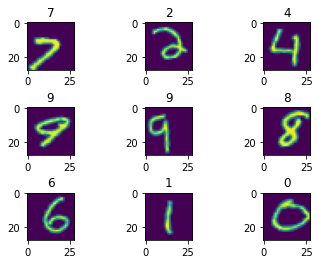

In [10]:
for i in range(9):
    img, lab = training_set.next()
    plt.subplot(3,3,i+1)
    plt.imshow(img[0])
    plt.subplots_adjust(hspace=0.8)
    plt.title(np.argmax(lab[0]))

In [11]:
# model_save_path = 'straight_bs200e30_tf25.h5'
# checkpoint_callback = ModelCheckpoint(model_save_path,
#                                       monitor='val_accuracy',
#                                       save_best_only=True,
#                                       verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # better than val_acc
                                               patience=3, 
                                               mode='auto', # default
                                               verbose=1)

In [12]:
history = classifier.fit(training_set,
                         steps_per_epoch=len(x_train)//batch_size, # 300
                         validation_data=test_set,
                         validation_steps=len(x_test)//batch_size, # 50
                         epochs=epochs,
                        #  callbacks=[checkpoint_callback])
                         callbacks=[es_callback])

Epoch 1/30
300/300 [==============================] - 25s 69ms/step - loss: 0.9103 - accuracy: 0.6928 - val_loss: 0.1440 - val_accuracy: 0.9544
Epoch 2/30
300/300 [==============================] - 21s 68ms/step - loss: 0.1449 - accuracy: 0.9563 - val_loss: 0.0733 - val_accuracy: 0.9760
Epoch 3/30
300/300 [==============================] - 20s 67ms/step - loss: 0.0915 - accuracy: 0.9719 - val_loss: 0.0580 - val_accuracy: 0.9815
Epoch 4/30
300/300 [==============================] - 22s 74ms/step - loss: 0.0766 - accuracy: 0.9760 - val_loss: 0.0500 - val_accuracy: 0.9842
Epoch 5/30
300/300 [==============================] - 21s 70ms/step - loss: 0.0627 - accuracy: 0.9813 - val_loss: 0.0445 - val_accuracy: 0.9853
Epoch 6/30
300/300 [==============================] - 21s 70ms/step - loss: 0.0546 - accuracy: 0.9824 - val_loss: 0.0496 - val_accuracy: 0.9846
Epoch 7/30
300/300 [==============================] - 21s 71ms/step - loss: 0.0465 - accuracy: 0.9858 - val_loss: 0.0357 - val_accuracy:

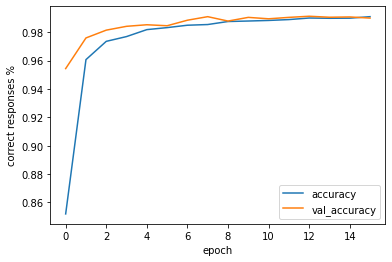

In [13]:
plt.plot(history.history['accuracy'],
         label='accuracy')
plt.plot(history.history['val_accuracy'],
         label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

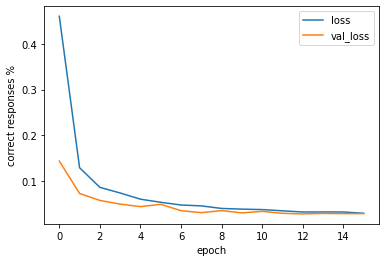

In [14]:
plt.plot(history.history['loss'],
         label='loss')
plt.plot(history.history['val_loss'],
         label='val_loss')
plt.xlabel('epoch')
plt.ylabel('correct responses %')
plt.legend()
plt.show()

In [15]:
classifier.save('es.h5')